---
title: 2025-11-16 Tessera Example
date: "11/16/2025"
categories:
- phd
- quarto
license: "CC BY"
copyright:
    holder: "Andrés C. Zúñiga-González"
    year: 2025
format: 
    html:
        code-fold: true
---

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')

from utils.paths import national_parks_dir, wdpa_dir
from gee_helpers import authenticate_ee, request_gee_image
from protected_area import ProtectedArea
from infrastructure.open_buildings import OpenBuildings
from classifiers.pixel_classifier import PixelClassifier
from embeddings.alpha_earth import AlphaEarthEmbeddings
from embeddings.geotessera import GeoTesseraEmbeddings
import pandas as pd
import geopandas as gpd
import ee
import xee
import eemont
from overturemaps import core
import xarray as xr
import rasterio
from rasterio import features
import numpy as np
import affine
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

authenticate_ee()


Successfully saved authorization token.


# Data

In [2]:
wdpa_files = list(wdpa_dir.rglob("*polygons.shp"))

In [3]:
wdpa_polygons = pd.concat([gpd.read_file(f) for f in wdpa_files])
wdpa_polygons['WDPAID'] = wdpa_polygons['WDPAID'].astype(int).astype(str)

In [4]:
# example_row = wdpa_polygons[wdpa_polygons["WDPAID"] == "555784094"]  # CIV: 555784094
# example = ProtectedArea(name=example_row["NAME"].values[0], 
#                         wdpaid=example_row["WDPAID"].values[0], 
#                         country_code=example_row["ISO3"].values[0],
#                         bbox=example_row.total_bounds.tolist())
example = ProtectedArea(name='Nairobi National Park', 
                        wdpaid='000000', 
                        country_code='KEN',
                        bbox=[36.747789403997196, -1.4398202050048914, 36.97884561842, -1.3045898658971178])
example


ProtectedArea(name='Nairobi National Park', wdpaid='000000', country_code='KEN', bbox=[36.747789403997196, -1.4398202050048914, 36.97884561842, -1.3045898658971178], climate_type='Csb', utm_crs='EPSG:32737', utm_bbox=[249399.0491072322, 9840732.461804673, 275107.1157634887, 9855713.033102514])

### Embeddings
#### AlphaEarth Embeddings

In [5]:
year = 2023
ae_2023 = AlphaEarthEmbeddings(protected_area=example, year=year)
ae_embeddings_2023_da = ae_2023.get_embeddings()
ae_embeddings_2023_da

2025-11-24 10:33:58.212 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'AlphaEarth' embeddings from /maps/acz25/phd-thesis-data/input/Google/AlphaEarth/2023/KEN/000000_ae.zarr
2025-11-24 10:33:58.746 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'AlphaEarth' embeddings


<xarray.DataArray (band: 64, y: 1498, x: 2571)> Size: 986MB
dask.array<rechunk-merge, shape=(64, 1498, 2571), dtype=float32, chunksize=(64, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) object 512B 'A00' 'A01' 'A02' 'A03' ... 'A61' 'A62' 'A63'
  * y        (y) float64 12kB 9.841e+06 9.841e+06 ... 9.856e+06 9.856e+06
  * x        (x) float64 21kB 2.494e+05 2.494e+05 ... 2.751e+05 2.751e+05
Attributes:
    crs:      EPSG:32737

#### Tessera Embeddings

In [6]:
year = 2024
gt_2024 = GeoTesseraEmbeddings(protected_area=example, year=year)
gt_embeddings_2024_da = gt_2024.get_embeddings()
gt_embeddings_2024_da

2025-11-24 10:34:00.447 | INFO     | embeddings.base:get_embeddings:46 - Loading cached 'GeoTessera' embeddings from /maps/acz25/phd-thesis-data/input/GEOTESSERA/clipped/2024/KEN/000000.zarr
2025-11-24 10:34:00.585 | INFO     | embeddings.base:get_embeddings:53 - Chunking 'GeoTessera' embeddings


<xarray.DataArray (band: 128, y: 1500, x: 2572)> Size: 2GB
dask.array<rechunk-merge, shape=(128, 1500, 2572), dtype=float32, chunksize=(128, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 1kB 'A001' 'A002' 'A003' ... 'A126' 'A127' 'A128'
  * y            (y) float64 12kB 9.856e+06 9.856e+06 ... 9.841e+06 9.841e+06
  * x            (x) float64 21kB 2.494e+05 2.494e+05 ... 2.751e+05 2.751e+05
    spatial_ref  int64 8B ...
Attributes:
    GEOTESSERA_VERSION:       0.6.0
    TESSERA_DATASET_VERSION:  v1
    TESSERA_DESCRIPTION:      GeoTessera satellite embedding tile
    TESSERA_TILE_LAT:         -1.45
    TESSERA_TILE_LON:         36.75
    TESSERA_YEAR:             2024
    AREA_OR_POINT:            Area
    scale_factor:             1.0
    add_offset:               0.0
    long_name:                ['Tessera_Band_0', 'Tessera_Band_1', 'Tessera_B...

### Infrastructure

#### Overture Maps

In [7]:
bbox = [ 0.08756552498492204, 52.16590292629015, 0.18025552851118945, 52.242523558881146]
bbox = example.bbox

In [8]:
roads = core.geodataframe('segment', bbox)
buildings = core.geodataframe('building', bbox)
infrastructure = core.geodataframe('infrastructure', bbox)
roads.crs = 'EPSG:4326'
buildings.crs = 'EPSG:4326'
infrastructure.crs = 'EPSG:4326'

In [9]:
# sources column contains a ndarray/dict per row, filter out both 'Google Open Buildings' and 'Microsoft ML Buildings'
def exclude_open_and_ml_buildings(sources):
    # sources can be a dict or a list/np.ndarray of dicts
    srcs = sources if isinstance(sources, (list, np.ndarray)) else [sources]
    wanted = {'OpenStreetMap'}
    # If any source has an unwanted dataset, exclude this row
    return any(src.get('dataset') in wanted for src in srcs)

mask = buildings['sources'].apply(exclude_open_and_ml_buildings)
filtered_buildings = buildings.copy()[mask]
filtered_infrastructure = infrastructure.copy()[infrastructure.geom_type.isin(['MultiPolygon', 'Polygon', 'LineString', 'MultiLineString'])]

In [11]:
osm_classes = {'roads': {'rail': {'rail': ['funicular', 'light_rail', 'monorail', 'narrow_gauge', 'standard_gauge', 'tram'], 
                                  'other_rail': ['unknown']},
                         'road': {'road': ['living_street', 'motorway', 'residential', 'primary', 'secondary', 'service', 'tertiary', 'track'], 
                                           'truck': ['truck'],
                                           'other_road': ['unclassified', 'unknown']},
                         'water': {'water': ['water']}},
               'buildings': ['outbuilding']}

In [12]:
def get_new_class(value, dict):
    for k, v in dict.items():
        if value in v:
            return k
    return 'other'

roads['new_class'] = roads.apply(lambda x: get_new_class(x['class'], osm_classes['roads'][x['subtype']]), axis=1)
filtered_buildings = filtered_buildings[filtered_buildings['subtype'] != 'outbuilding']
filtered_buildings['new_class'] = 'building'
filtered_infrastructure['new_class'] = 'infrastructure'

In [13]:
# 1. Choose the reference transform and shape (use AlphaEarth embeddings, infra, or buildings as reference)
# We'll use the ae_infra_pred_roi_da (assumed to be an xarray DataArray with x/y dims and crs)
reference_da = ae_embeddings_2023_da  # Should be defined in the notebook above

transform = reference_da.rio.transform() if hasattr(reference_da, "rio") else affine.Affine(
    (reference_da.x[1] - reference_da.x[0]).item(), 0, reference_da.x[0].item(),
    0, (reference_da.y[1] - reference_da.y[0]).item(), reference_da.y[0].item()
)
out_shape = (len(reference_da.y), len(reference_da.x))

# Prepare the geometries and their values for rasterization
# Assign values:
#   1 = building  (filtered_buildings)
#   2 = road      (roads)
#   3 = infrastructure

shapes = []
filtered_buildings = filtered_buildings.to_crs(example.utm_crs)
roads = roads.to_crs(example.utm_crs)
filtered_infrastructure = filtered_infrastructure.to_crs(example.utm_crs)
# Buildings
for g in filtered_buildings.geometry:
    if g is not None and not g.is_empty:
        shapes.append((g, 1))
# Roads
for g in roads.geometry:
    if g is not None and not g.is_empty:
        shapes.append((g, 2))
# Infrastructure
for g in filtered_infrastructure.geometry:
    if g is not None and not g.is_empty:
        shapes.append((g, 3))

# Rasterize
raster = features.rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='float32'
)


In [14]:
# Add "band" coordinate with value "overture" to the raster DataArray
overture_da = xr.DataArray(
    raster[None, :, :],  # add a new axis for band
    dims=('band', 'y', 'x'),
    coords={'band': ['overture'], 'y': reference_da.y, 'x': reference_da.x},
).rio.write_crs(example.utm_crs)

overture_da

<xarray.DataArray (band: 1, y: 1498, x: 2571)> Size: 15MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [2., 0., 2., ..., 0., 0., 0.],
        [0., 2., 2., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.]]],
      shape=(1, 1498, 2571), dtype=float32)
Coordinates:
  * band         (band) <U8 32B 'overture'
  * y            (y) float64 12kB 9.841e+06 9.841e+06 ... 9.856e+06 9.856e+06
  * x            (x) float64 21kB 2.494e+05 2.494e+05 ... 2.751e+05 2.751e+05
    spatial_ref  int64 8B 0

# Classifier
## Binary

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=2000, random_state=411)

new_class_dict = {0:0, 1: 1, 2:1, 3:1}

### AlphaEarth

In [16]:
ae_infra_classifier = PixelClassifier()
ae_infra_classifier._classifier = mlp_classifier
X, y, coords, labels_da = ae_infra_classifier.prepare_data(overture_da, ae_embeddings_2023_da, "overture", 2000)

2025-11-24 10:41:19.248 | INFO     | classifiers.pixel_classifier:prepare_data:90 - Preparing data for band overture
2025-11-24 10:41:19.382 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band overture
2025-11-24 10:41:21.091 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 8000 coordinates


In [17]:
ae_infra_classifier.train()

2025-11-24 10:41:54.241 | INFO     | classifiers.pixel_classifier:train:129 - ✅ Model training complete.


,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True
,random_state,411


2025-11-24 10:41:54.293 | INFO     | classifiers.pixel_classifier:evaluate:137 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           0       0.69      0.70      0.70       600
           1       0.67      0.72      0.69       600
           2       0.55      0.53      0.54       600
           3       0.88      0.83      0.85       600

    accuracy                           0.70      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.70      0.70      0.70      2400



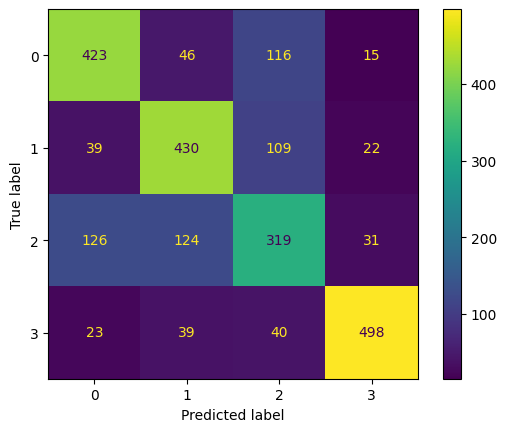

In [18]:
y_ae_infra_test_pred = ae_infra_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(ae_infra_classifier._classifier, ae_infra_classifier._X_test, ae_infra_classifier._y_test)

In [19]:
ae_infra_pred_roi_da = ae_infra_classifier.classify_roi(ae_embeddings_2023_da)
ae_infra_pred_roi_da = ae_infra_pred_roi_da.rio.write_crs(example.utm_crs)
ae_infra_pred_roi_da

2025-11-24 10:41:54.575 | INFO     | classifiers.pixel_classifier:classify_roi:148 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 1498, x: 2571)> Size: 31MB
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], shape=(1498, 2571))
Coordinates:
  * y            (y) float64 12kB 9.841e+06 9.841e+06 ... 9.856e+06 9.856e+06
  * x            (x) float64 21kB 2.494e+05 2.494e+05 ... 2.751e+05 2.751e+05
    spatial_ref  int64 8B 0

### Tessera

In [20]:
gt_infra_classifier = PixelClassifier()
gt_infra_classifier._classifier = mlp_classifier
X, y, coords, labels_da = gt_infra_classifier.prepare_data(overture_da, gt_embeddings_2024_da, "overture", 2000)

2025-11-24 10:42:43.902 | INFO     | classifiers.pixel_classifier:prepare_data:90 - Preparing data for band overture
2025-11-24 10:42:44.006 | INFO     | classifiers.pixel_classifier:_sample_classes:26 - Sampling classes for band overture
2025-11-24 10:42:46.176 | INFO     | classifiers.pixel_classifier:_extract_embeddings:55 - Extracting embeddings for 8000 coordinates


In [21]:
gt_infra_classifier.train()

2025-11-24 10:43:09.032 | INFO     | classifiers.pixel_classifier:train:129 - ✅ Model training complete.


,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True
,random_state,411


2025-11-24 10:43:09.079 | INFO     | classifiers.pixel_classifier:evaluate:137 - 
--- 📊 Classification Report ---


              precision    recall  f1-score   support

           0       0.69      0.66      0.68       600
           1       0.67      0.69      0.68       600
           2       0.51      0.53      0.52       600
           3       0.78      0.76      0.77       600

    accuracy                           0.66      2400
   macro avg       0.66      0.66      0.66      2400
weighted avg       0.66      0.66      0.66      2400



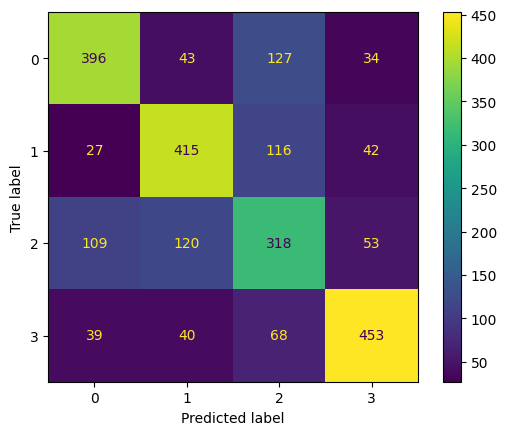

In [22]:
y_gt_infra_test_pred = gt_infra_classifier.evaluate()
ConfusionMatrixDisplay.from_estimator(gt_infra_classifier._classifier, gt_infra_classifier._X_test, gt_infra_classifier._y_test)

In [23]:
gt_infra_pred_roi_da = gt_infra_classifier.classify_roi(gt_embeddings_2024_da)
gt_infra_pred_roi_da = gt_infra_pred_roi_da.rio.write_crs(example.utm_crs)
gt_infra_pred_roi_da

2025-11-24 10:43:09.323 | INFO     | classifiers.pixel_classifier:classify_roi:148 - Classifying entire ROI


<xarray.DataArray 'predicted_class' (y: 1500, x: 2572)> Size: 31MB
array([[2, 2, 2, ..., 0, 0, 2],
       [2, 2, 2, ..., 0, 0, 2],
       [2, 2, 2, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 1, 1, 2],
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 1, 2, 2]], shape=(1500, 2572))
Coordinates:
  * y            (y) float64 12kB 9.856e+06 9.856e+06 ... 9.841e+06 9.841e+06
  * x            (x) float64 21kB 2.494e+05 2.494e+05 ... 2.751e+05 2.751e+05
    spatial_ref  int64 8B 0

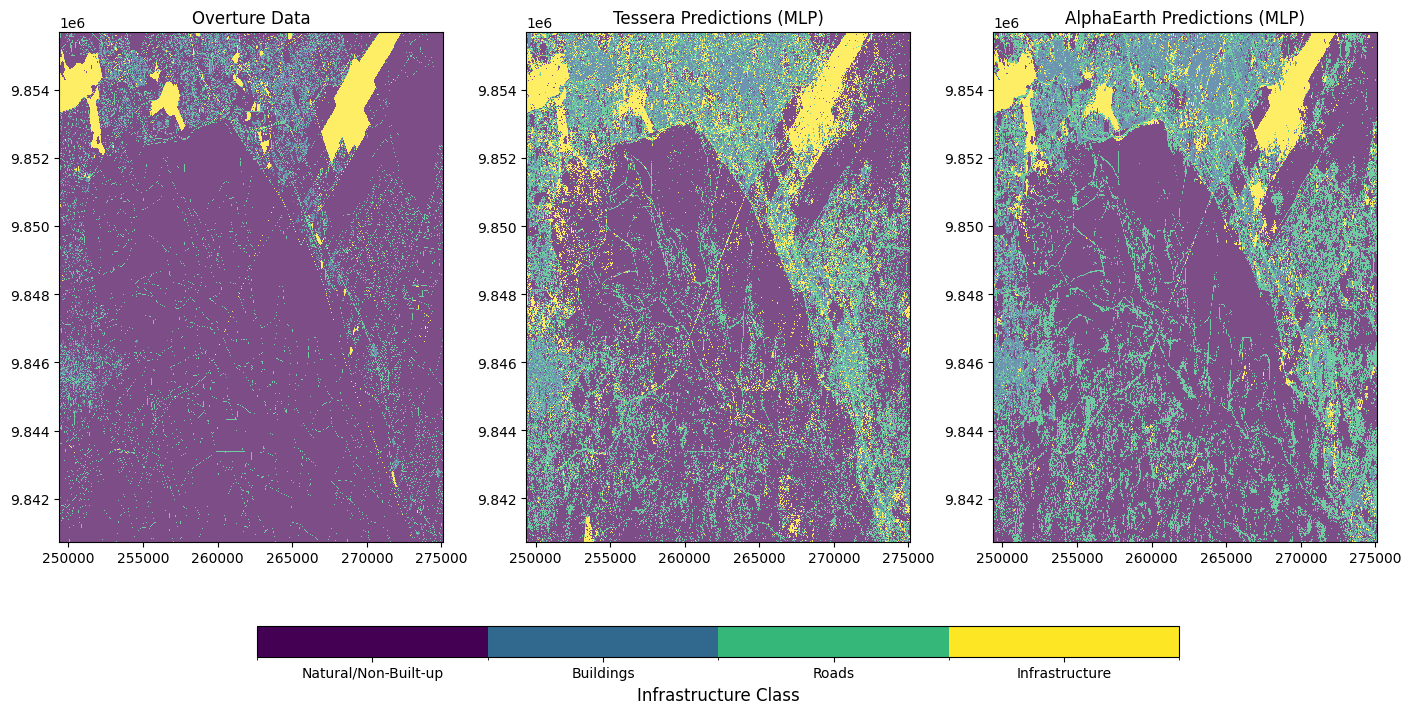

In [24]:
import matplotlib.cm as cm
# --- Your Setup Code ---
num_classes = 4
# Get the viridis colormap, sampled into num_classes discrete colors
viridis = plt.get_cmap('viridis', num_classes)
# Create a ListedColormap
discrete_cmap = ListedColormap([viridis(i) for i in range(num_classes)])

cmap = discrete_cmap
# Create boundaries for the discrete classes. 
# For classes 0, 1, 2, boundaries are -0.5, 0.5, 1.5, 2.5
boundaries = np.arange(num_classes + 1) - 0.5
# Create a BoundaryNorm to map data values to colors
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# --- Plotting ---

# Create the figure and axes
# We can use constrained_layout=True to help manage space
fig, axs = plt.subplots(1, 3, figsize=(14, 7), constrained_layout=True)

# Plot the OpenBuildings infrastructure band
overture_da.sel(band='overture').plot(
    ax=axs[0],
    alpha=0.7,
    cmap=cmap,       # Apply discrete cmap
    norm=norm,       # Apply discrete norm
    add_colorbar=False # --- KEY: Disable individual colorbar
)
# Plot the example_row geometry outline on top
# A boundary line usually has a single color
axs[0].set_title("Overture Data")
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)


# Plot the ground truth data
gt_infra_pred_roi_da.plot(
    ax=axs[1],
    alpha=0.7,
    cmap=cmap,       # Apply discrete cmap
    norm=norm,       # Apply discrete norm
    add_colorbar=False # --- KEY: Disable individual colorbar
)
axs[1].set_title("Tessera Predictions (MLP)")
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)

# Plot the ground truth data
ae_infra_pred_roi_da.plot(
    ax=axs[2],
    alpha=0.7,
    cmap=cmap,       # Apply discrete cmap
    norm=norm,       # Apply discrete norm
    add_colorbar=False # --- KEY: Disable individual colorbar
)
axs[2].set_title("AlphaEarth Predictions (MLP)")
axs[2].set_xlabel(None)
axs[2].set_ylabel(None)

# --- Create the single, discrete colorbar at the bottom ---

# 1. Create a ScalarMappable object to pass to the colorbar function
# This object links the colormap and normalization
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # You can pass an empty array

# 2. Add the colorbar to the figure
# - orientation='horizontal' places it at the bottom
# - ax=axs places it relative to the axes array
# - shrink, pad, aspect are for styling
cbar = fig.colorbar(
    sm,
    ax=axs, # Use the array of axes
    orientation='horizontal',
    pad=0.1,    # Padding from the subplots
    shrink=0.7, # Make it 70% of the total width
    aspect=30   # Ratio of long to short side
)

# 3. Set discrete ticks and labels
# We want ticks to be in the *middle* of each class boundary
# For classes 0, 1, 2, the centers are 0, 1, 2
tick_locs = np.arange(num_classes)
cbar.set_ticks(tick_locs)
# You can set custom labels here if you want
cbar.set_ticklabels(['Natural/Non-Built-up', 'Buildings', 'Roads', 'Infrastructure'])
cbar.set_label("Infrastructure Class", fontsize=12)

# Show the plot
plt.show()


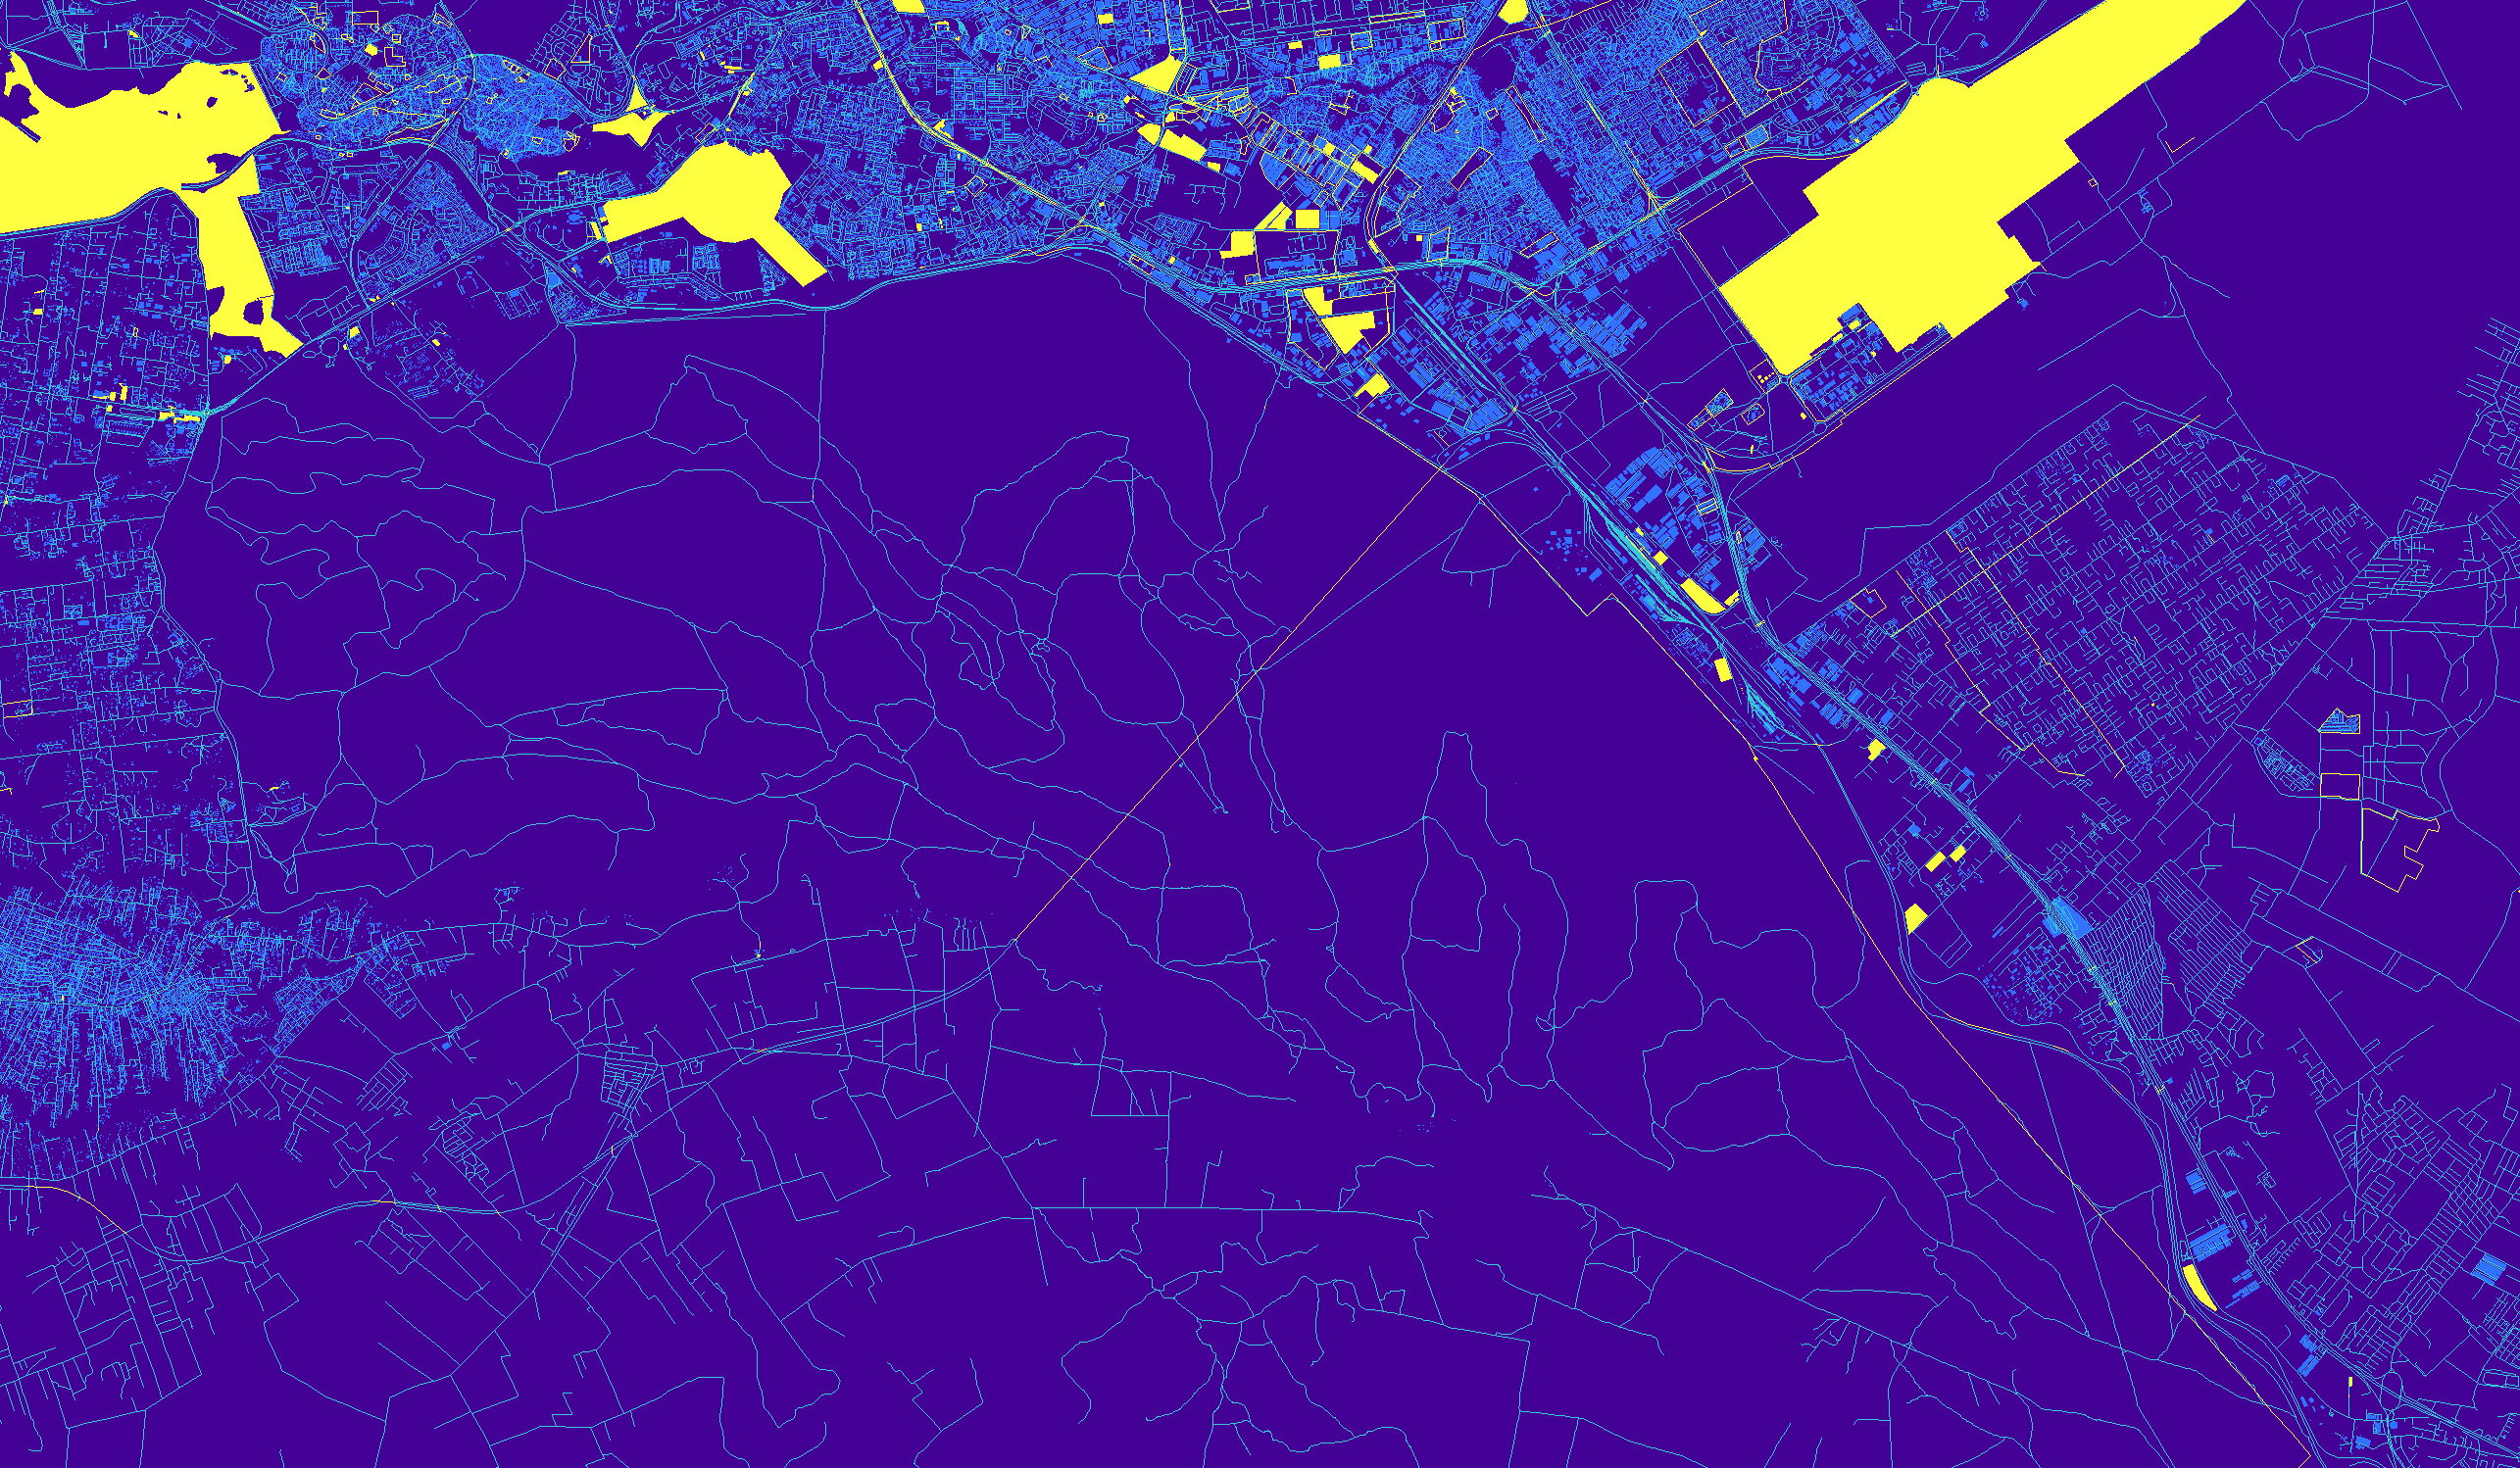
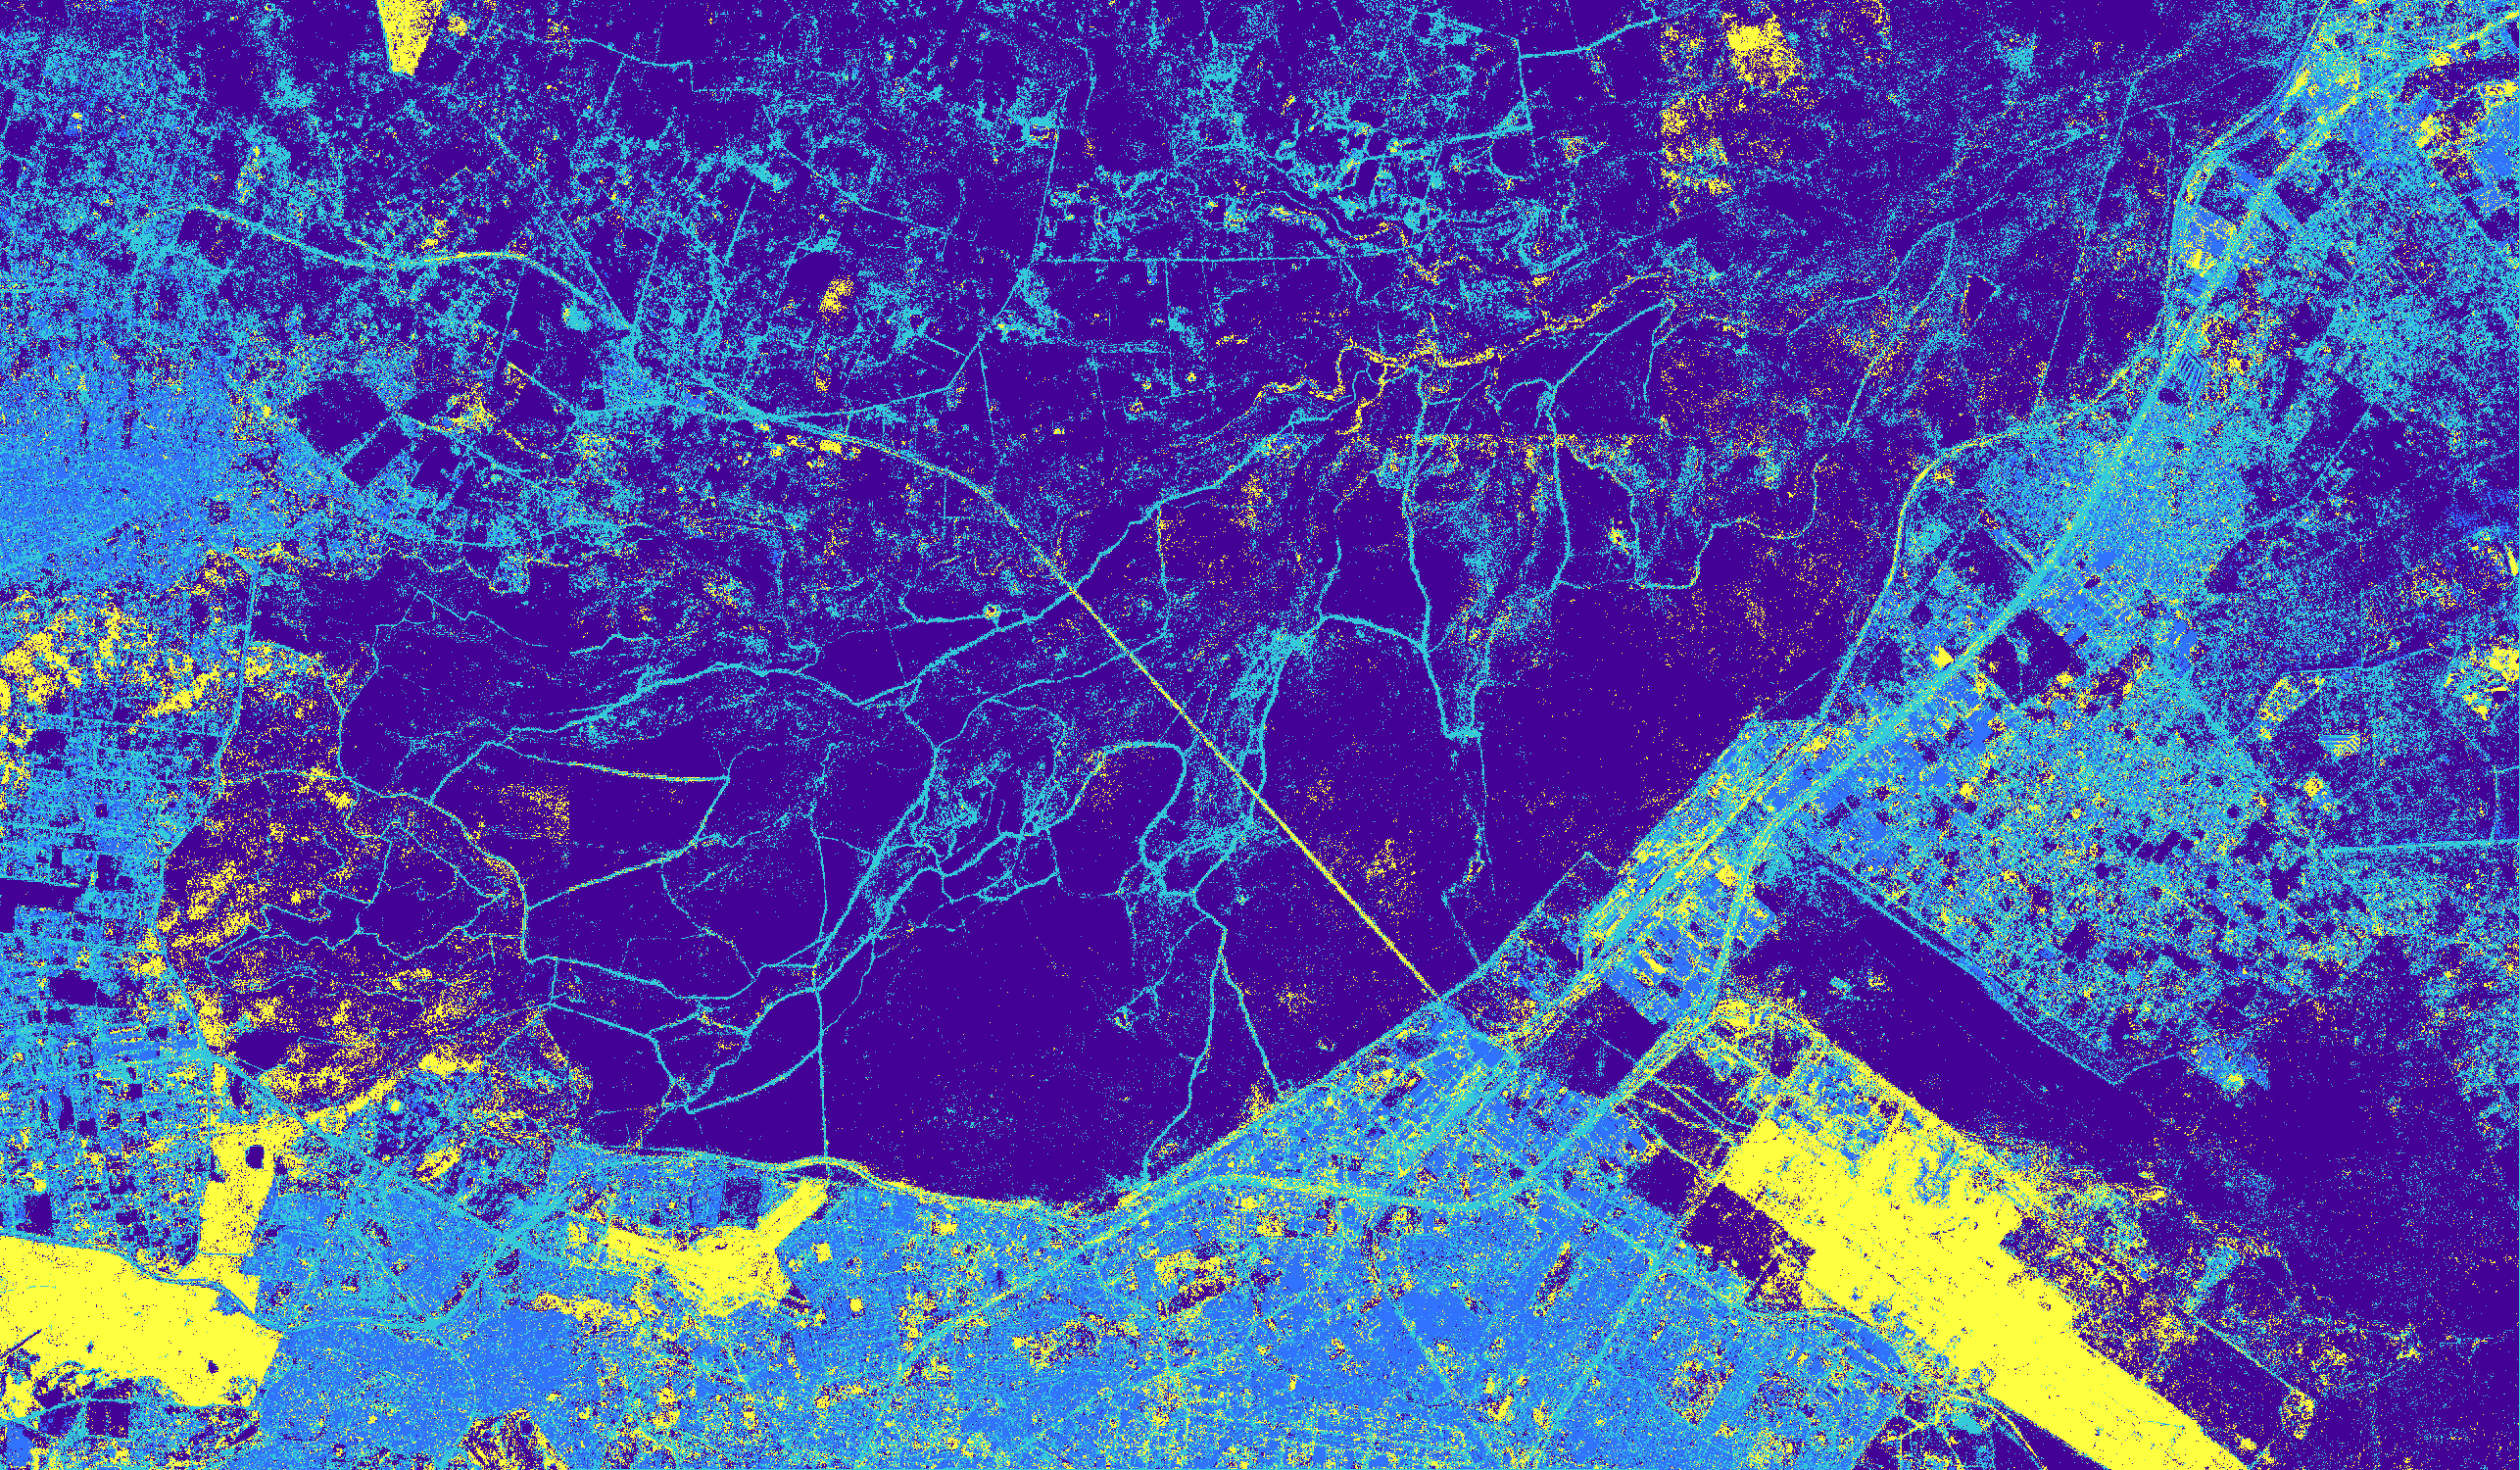
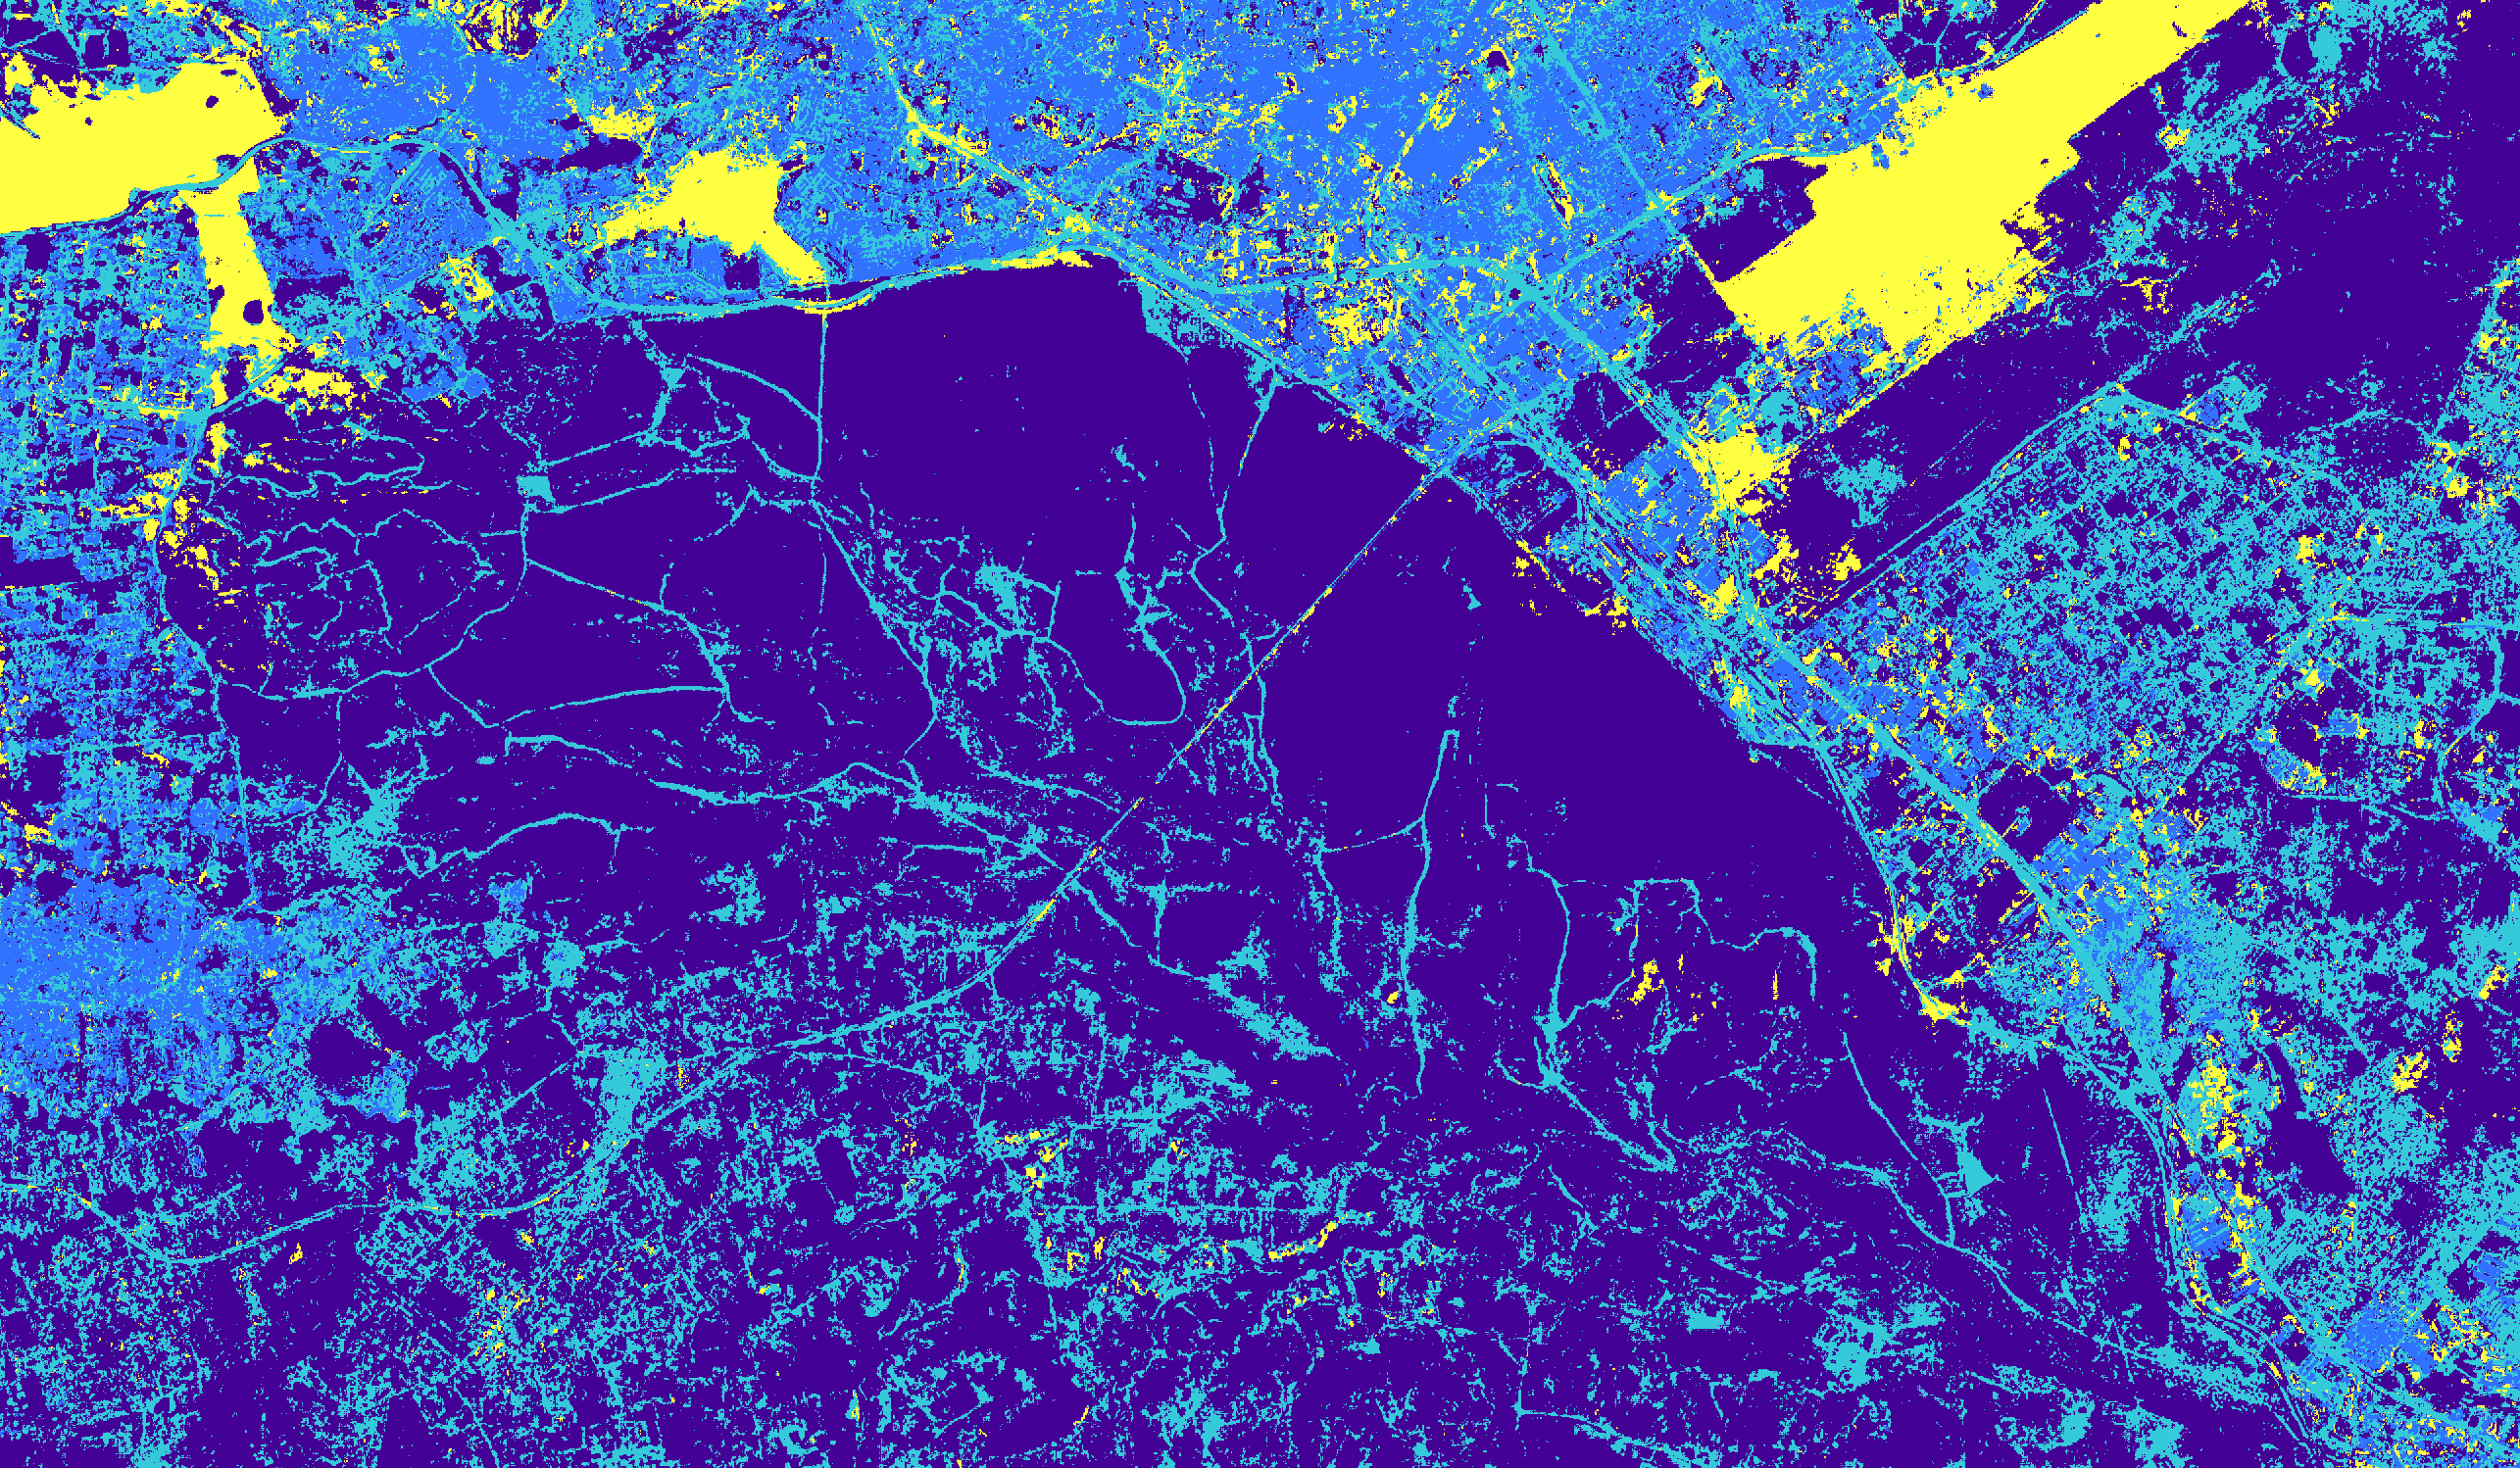

In [25]:
import branca.colormap as cm
import folium
# --- Colormap Setup (for Folium/Branca) ---
num_classes = 4
# Get the same discrete viridis colors from matplotlib
viridis = plt.get_cmap('viridis', num_classes)
# Get the hex codes, which branca understands
colors_hex = [mcolors.to_hex(viridis(i)) for i in range(num_classes)]

# Create the boundaries for classes 0, 1, 2
boundaries = np.arange(num_classes + 1) - 0.5
# Create a StepColormap for Branca
# This maps values in bins:
# [-0.5, 0.5] -> color 0
# [ 0.5, 1.5] -> color 1
# [ 1.5, 2.5] -> color 2
cmap_branca = cm.StepColormap(
    colors_hex,
    index=boundaries,
    vmin=boundaries[0],
    vmax=boundaries[-1],
    caption=f'Infrastructure Class (Discrete {num_classes}-class Viridis)'
)

bbox = example.bbox  # [min_lon, min_lat, max_lon, max_lat]
bounds = [[bbox[1], bbox[0]], [bbox[3], bbox[2]]]  # [[south, west], [north, east]]

# Center for the map
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

# --- Create the Folium Map ---
m = folium.Map(location=center, zoom_start=14, tiles="OpenStreetMap")

# --- Add Data Layers ---
# We use FeatureGroups to make the layers toggleable

# 1. Overture Data Layer
overture_group = folium.FeatureGroup(name='Overture Data', show=True).add_to(m)
folium.raster_layers.ImageOverlay(
    image=np.flipud(overture_da.sel(band='overture').values), # Pass the 2D numpy array
    bounds=bounds,
    opacity=0.7,
    colormap=cmap_branca, # Pass the branca colormap
).add_to(overture_group)

# 2. Ground Truth Layer
gt_group = folium.FeatureGroup(name='Tessera', show=False).add_to(m)
folium.raster_layers.ImageOverlay(
    image=np.flipud(gt_infra_pred_roi_da.values), # This array is already 2D
    bounds=bounds,
    opacity=0.7,
    colormap=cmap_branca
).add_to(gt_group)

# 3. AE Infra Prediction Layer
ae_group = folium.FeatureGroup(name='AlphaEarth', show=False).add_to(m)
folium.raster_layers.ImageOverlay(
    image=np.flipud(ae_infra_pred_roi_da.values), # This array is already 2D
    bounds=bounds,
    opacity=0.7,
    colormap=cmap_branca
).add_to(ae_group)

# --- Add the Colormap Legend and Layer Control ---
cmap_branca.add_to(m)
folium.LayerControl().add_to(m)
m

In [49]:
# Ensure the DataArray has proper dtype, integer values (for class IDs), and CRS before saving

# Convert to integer type (class IDs)
out_da = ae_infra_pred_roi_da.astype("uint8")

# Ensure the spatial_ref CRS attribute exists and is valid
if not out_da.rio.crs:
    # Try to set CRS from original source if missing
    out_da = out_da.rio.write_crs("EPSG:32629", inplace=False)  # Adjust to your actual UTM CRS

# Remove any singleton bands dimension (make 2D)
if "band" in out_da.dims and out_da.sizes["band"] == 1:
    out_da = out_da.squeeze("band", drop=True)

# Remove NaNs (replace with a nodata value)
nodata_value = 255
out_da = out_da.fillna(nodata_value)
out_da.rio.write_nodata(nodata_value, inplace=True)

out_da.rio.to_raster("ae_infra_pred_roi_da.tif")

# Google Earth

In [46]:
collection = request_gee_image('COPERNICUS/S2_HARMONIZED', date='2024-11-05', date_end='2025-11-05', bbox=example.bbox).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
composite = collection.median()

In [ ]:
import geemap
# Visualization parameters for Sentinel-2 RGB
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

roi = ee.Geometry.Rectangle(example.bbox)

# Create a geemap interactive map, centered on the ROI
center = [(example.bbox[1] + example.bbox[3])/2, (example.bbox[0] + example.bbox[2])/2]
m = geemap.Map(center=center, zoom=9)
m.addLayer(composite, vis_params, 'Sentinel-2 RGB Composite')
m.addLayer(geemap.gdf_to_ee(example_row), {}, 'ROI')
m.addLayer(roi, {}, 'bbox')

m